In [1]:
import datetime

import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


import string
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer

from nltk.stem.snowball import EnglishStemmer
import nltk

import pickle

from sklearn.decomposition import LatentDirichletAllocation

In [2]:
business = pd.read_json('yelp_dataset/business.json', lines=True)
#checkin = pd.read_json('yelp_dataset/checkin.json', lines=True)
#photo = pd.read_json('yelp_dataset/photo.json', lines=True)
#review =  pd.read_json('yelp_dataset/review.json', lines=True)
#tip = pd.read_json('yelp_dataset/tip.json', lines=True)
##user = pd.read_json('yelp_dataset/user.json', lines=True)

In [3]:
business.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,None,0,33.522143,-112.018481,Arizona Biltmore Golf Club,85016,5,3.0,AZ
1,30 Eglinton Avenue W,"{'RestaurantsReservations': 'True', 'GoodForMe...",QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",1,43.605499,-79.652289,Emerald Chinese Restaurant,L5R 3E7,128,2.5,ON
2,"10110 Johnston Rd, Ste 15","{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...",gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese",Charlotte,"{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",1,35.092564,-80.859132,Musashi Japanese Restaurant,28210,170,4.0,NC
3,"15655 W Roosevelt St, Ste 237",None,xvX2CttrVhyG2z1dFg_0xw,"Insurance, Financial Services",Goodyear,"{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",1,33.455613,-112.395596,Farmers Insurance - Paul Lorenz,85338,3,5.0,AZ
4,"4209 Stuart Andrew Blvd, Ste F","{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...",HhyxOkGAM07SRYtlQ4wMFQ,"Plumbing, Shopping, Local Services, Home Servi...",Charlotte,"{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...",1,35.190012,-80.887223,Queen City Plumbing,28217,4,4.0,NC


## Helper Function

In [4]:
def text_process(text):
    """
    Modified from
    http://adataanalyst.com/scikit-learn/countvectorizer-sklearn-example/
    Takes in a string of text, then performs the following:
    1. Remove all punctuation, and digits 
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    stemmer = EnglishStemmer()
   
    # Check characters to see if they are in punctuation
    clean = [char for char in text if (char not in string.punctuation) 
            and (not char.isdigit())] 
 
    clean = ''.join(clean)
    tokens = clean.split()
    tokens = [stemmer.stem(c) for c in tokens]
    # Join the characters again to form the string.

    tokens = ' '.join(tokens)
    
    # Now just remove any stopwords
    return tokens

### Only look at restaurants

#lv_restaurants
restaurants = business['categories'].str.contains('Restaurants', regex=False)
restaurants = restaurants.fillna(False)
restaurants = business[restaurants]
print(restaurants.shape)
restaurants.head()

categories_df = pd.Series(restaurants['categories']).str.get_dummies(sep=', ')

categories_df.head()

totals = categories_df.sum().sort_values(ascending=False)

plt.barh(totals[11:1:-1].keys(),totals[11:1:-1], 0.5,  align='center')
plt.title('Top Ten Restaurants Categories')
plt.ylabel('Categories')
plt.xlabel('Frequency')

nightlife = restaurants['categories'].str.contains('Nightlife', regex=False)
nightlife = nightlife.fillna(False)
nightlife = restaurants[nightlife]

pizza = restaurants['categories'].str.contains('Pizza', regex=False)
pizza = pizza.fillna(False)
pizza = restaurants[pizza]

burgers = restaurants['categories'].str.contains('Burgers', regex=False)
burgers = burgers.fillna(False)
burgers = restaurants[burgers]
burgers.head()

plt.hist(nightlife['stars'], bins = 10)
plt.title('Distribution of Stars for Nightlife')
plt.ylabel('Restaurants with Ratings')
plt.xlabel('Rating')

plt.hist(pizza['stars'], bins = 10)
plt.title('Distribution of Stars for Pizza')
plt.ylabel('Restaurants with Ratings')
plt.xlabel('Rating')

plt.hist(burgers['stars'], bins = 10)
plt.title('Distribution of Stars for Burgers')
plt.ylabel('Restaurants with Ratings')
plt.xlabel('Rating')

X_train, X_test, y_train, y_test = train_test_split(categories_df, \
                                                    restaurants['stars'], test_size=0.33, random_state=42)


#X_train = pd.Series(X_train).str.get_dummies(sep=', ')
#X_test = pd.Series(X_test).str.get_dummies(sep=', ')

### Vectorized value to get categories
#vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1))
#categories_count = vectorizer.fit_transform(restaurants['categories']).astype(np.int8)
#categories_list = vectorizer.get_feature_names()
#categories_df = pd.DataFrame(categories_count.toarray())
#categories_df.columns = categories_list
#categories_df.head()

#check for columns missing from test set
#missing_train = list(set(list(X_train)) - set(list(X_test)))
#for col in missing_train:
#    X_test[col] = 0
    
#missing_test = list(set(list(X_test)) - set(list(X_train)))
#for col in missing_test:
#    X_train[col] = 0

X_train.head()

X_test.head()

print(X_train.shape)
print(X_test.shape)

y_train_cut = pd.cut(np.array(y_train), 2, labels=[1, 2])
y_test_cut = pd.cut(np.array(y_test), 2, labels=[1, 2])
np.array(y_train_cut)

## KNN Neighbor

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, np.array(y_train_cut)) 

np.array(y_test_cut)

neigh.score(X_test, np.array(y_test_cut))

y_pred = neigh.predict(X_test)

accuracy_score(y_test_cut, y_pred)

## Linear regression

#### Ridge

reg = linear_model.Ridge(alpha=.5)

reg.fit(X_train, y_train)


y_pred = reg.predict(X_test)
y_pred = pd.Series(y_pred)

y_pred.shape

y_test.shape

mean_squared_error(y_test, y_pred)

r2_score(y_test, y_pred)  

#### Standard

regL = linear_model.LinearRegression()

regL.fit(X_train, y_train)


y_pred = regL.predict(X_test)
y_pred = pd.Series(y_pred)

y_pred.shape

y_test.shape

mean_squared_error(y_test, y_pred)

r2_score(y_test, y_pred)  

## Reviews

##The Whole dataset, but running into memory issues
#start = datetime.datetime.now()

#iter_review =  pd.read_json('yelp_dataset/review.json', lines=True, chunksize=500)
#reviews_df = pd.concat([df[df['business_id'].isin(set(df['business_id']).intersection(set(restaurants['business_id'])))] for df in iter_review])

#end = datetime.datetime.now()
#elapse = end-start
#print(elapse.seconds)

reviews_df_file = open("reviews_df_file",'wb')
pickle.dump(reviews_df,reviews_df_file)
reviews_df_file.close()

reviews_df_file = open("reviews_df_file",'rb')
reviews_df_2 = pickle.load(reviews_df_file)
reviews_df_file.close()

reviews_df = pd.DataFrame()
start = datetime.datetime.now()
for df in pd.read_json('yelp_dataset/review.json', lines=True,  chunksize=1000):
    reviews_df = df[df['business_id'].isin(set(df['business_id']).intersection(set(restaurants['business_id'])))]
end = datetime.datetime.now()
elapse = end-start
print(elapse.seconds)

reviews_df.head()

reviews_df.stars.plot(kind='hist')

reviews_df.text

## keep the size to 1000 features for size
start = datetime.datetime.now()

reviews_df.text = reviews_df.text.apply(text_process)
vectorizer = TfidfVectorizer(analyzer='word',min_df=10, stop_words = stop_words.ENGLISH_STOP_WORDS, 
                             ngram_range=(1, 2))
text_tfidf = vectorizer.fit_transform(reviews_df.text)
text_features = vectorizer.get_feature_names()
text_sparse_df = pd.SparseDataFrame(text_tfidf)
text_sparse_df.columns = text_features
text_sparse_df.fillna(0.0, inplace=True)

end = datetime.datetime.now()
elapse = end-start

print(elapse.seconds)

reviews_df.text

count_vectorizer = CountVectorizer(analyzer='word',min_df=5, stop_words = stop_words.ENGLISH_STOP_WORDS, 
                             ngram_range=(1, 1))
text_count = count_vectorizer.fit_transform(reviews_df.text)
text_count_features = count_vectorizer.get_feature_names()
text_count_df = pd.SparseDataFrame(text_count)
text_count_df.columns = text_count_features
text_count_df.fillna(0.0, inplace=True)

text_count_df.head()

text_count_totals = text_count_df.sum().sort_values(ascending=False)

plt.barh(text_count_totals[11::-1].keys(),text_count_totals[11::-1], 0.5,  align='center')
plt.title('Top Ten Words in Reviews')
plt.ylabel('Words')
plt.xlabel('Frequency')

countn_vectorizer = CountVectorizer(analyzer='word',min_df=5, stop_words = stop_words.ENGLISH_STOP_WORDS, 
                             ngram_range=(2, 4))
text_countn = countn_vectorizer.fit_transform(reviews_df.text)
text_countn_features = countn_vectorizer.get_feature_names()
text_countn_df = pd.SparseDataFrame(text_countn)
text_countn_df.columns = text_countn_features
text_countn_df.fillna(0.0, inplace=True)

text_countn_totals = text_countn_df.sum().sort_values(ascending=False)

plt.barh(text_countn_totals[11::-1].keys(),text_countn_totals[11::-1], 0.5,  align='center')
plt.title('Top Ten Bigram in Reviews')
plt.ylabel('Phrases')
plt.xlabel('Frequency')

good_reviews = reviews_df[reviews_df.stars >= 4.0]
good_reviews.head()

textg_countn = countn_vectorizer.fit_transform(good_reviews.text)
textg_countn_features = countn_vectorizer.get_feature_names()
textg_countn_df = pd.SparseDataFrame(textg_countn)
textg_countn_df.columns = textg_countn_features
textg_countn_df.fillna(0.0, inplace=True)

textg_countn_totals = textg_countn_df.sum().sort_values(ascending=False)

plt.barh(textg_countn_totals[7::-1].keys(),textg_countn_totals[7::-1], 0.5,  align='center')
plt.title('Top Bigrams in Good Reviews')
plt.ylabel('Phrases')
plt.xlabel('Frequency')

bad_reviews = reviews_df[reviews_df.stars <= 2.0]
bad_reviews.head()

textb_countn = countn_vectorizer.fit_transform(bad_reviews.text)
textb_countn_features = countn_vectorizer.get_feature_names()
textb_countn_df = pd.SparseDataFrame(textb_countn)
textb_countn_df.columns = textb_countn_features
textb_countn_df.fillna(0.0, inplace=True)

textb_countn_totals = textb_countn_df.sum().sort_values(ascending=False)

plt.barh(textb_countn_totals[7::-1].keys(),textb_countn_totals[7::-1], 0.5,  align='center')
plt.title('Top Bigrams in Bad Reviews')
plt.ylabel('Phrases')
plt.xlabel('Frequency')

X_train, X_test, y_train, y_test = train_test_split(text_sparse_df, \
                                                    reviews_df.stars, test_size=0.33, random_state=42)


X_train.head()

## Models

reg = linear_model.Ridge(alpha=.5)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
y_pred = pd.Series(y_pred)

print("MSE:" + str(mean_squared_error(y_test, y_pred)))
print("R2:"+ str(r2_score(y_test, y_pred)))

ridgereg = linear_model.Ridge()
alpha_range = [10, 1, 0.1, 0.01, 0.001]
ridge_params = {'alpha': alpha_range}
ridge_grid = GridSearchCV(ridgereg, ridge_params, cv=10, scoring='neg_mean_squared_error', n_jobs = 4, return_train_score=True)
ridge_grid.fit(X_train, np.ravel(y_train))
ridge_results = pd.DataFrame(ridge_grid.cv_results_)
ridge_results.sort_values(by='rank_test_score').head(5)

regL = linear_model.LinearRegression()
regL.fit(X_train, y_train)
y_pred_regL = regL.predict(X_test)
y_pred_regL = pd.Series(y_pred)

print("MSE:" + str(mean_squared_error(y_test, y_pred_regL)))
print("R2:"+ str(r2_score(y_test, y_pred_regL)))

### LDA Topic Modeling

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print( " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

n_components_range = [10,15,20,25,30]
learning_decay_range = [0.5,0.7,0.9]
search_params = {'n_components': n_components_range, 'learning_decay': learning_decay_range}

lda = LatentDirichletAllocation(max_iter=10, learning_method='online')
lda_model = GridSearchCV(lda, param_grid=search_params, n_jobs=4)

start = datetime.datetime.now()

lda_model.fit(text_count_df)

end = datetime.datetime.now()
elapse = end-start
print(elapse.seconds)

# Best Model
best_lda_model = lda_model.best_estimator_

# Model Parameters
print("Best Model's Params: ", lda_model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", lda_model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(text_count_df))

# Create Document - Topic Matrix
lda_output = best_lda_model.transform(text_count_df)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(text_count_df))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

no_top_words = 2
display_topics(best_lda_model, text_count_features, no_top_words)

## Control for price, location, type of restaurant

In [5]:
#https://github.com/pandas-dev/pandas/issues/18152

max_records = 1e5
df = pd.read_json('yelp_dataset/review.json', lines=True, chunksize=max_records)
reviews = pd.DataFrame() # Initialize the dataframe
try:
   for df_chunk in df:
       reviews = pd.concat([reviews, df_chunk])
except ValueError:
       print ('\nSome messages in the file cannot be parsed')

In [6]:
print(reviews.shape)
reviews.head()

(6685900, 9)


,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,ujmEBvifdJM6h6RLv4wQIg,0,2013-05-07 04:34:36,1,Q1sbwvVQXV2734tPgoKj4Q,1,Total bill for this horrible service? Over $8G...,6,hG7b0MtEbXx5QzbzE6C_VA
1,NZnhc2sEQy3RmzKTZnqtwQ,0,2017-01-14 21:30:33,0,GJXCdrto3ASJOqKeVWPi6Q,5,I *adore* Travis at the Hard Rock's new Kelly ...,0,yXQM5uF2jS6es16SJzNHfg
2,WTqjgwHlXbSFevF32_DJVw,0,2016-11-09 20:09:03,0,2TzJjDVDEuAW6MR5Vuc1ug,5,I have to say that this office really has it t...,3,n6-Gk65cPZL6Uz8qRm3NYw
3,ikCg8xy5JIg_NGPx-MSIDA,0,2018-01-09 20:56:38,0,yi0R0Ugj_xUx_Nek0-_Qig,5,Went in for a lunch. Steak sandwich was delici...,0,dacAIZ6fTM6mqwW5uxkskg
4,b1b1eb3uo-w561D0ZfCEiQ,0,2018-01-30 23:07:38,0,11a8sVPMUFtaC7_ABRkmtw,1,Today was my second out of three sessions I ha...,7,ssoyf2_x0EQMed6fgHeMyQ


In [7]:
joined = reviews.join(business, lsuffix='_r', rsuffix='_v', how="inner")

In [8]:
print(joined.shape)
joined.head()

(192609, 23)


,business_id_r,cool,date,funny,review_id,stars_r,text,useful,user_id,address,...,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars_v,state
0,ujmEBvifdJM6h6RLv4wQIg,0,2013-05-07 04:34:36,1,Q1sbwvVQXV2734tPgoKj4Q,1,Total bill for this horrible service? Over $8G...,6,hG7b0MtEbXx5QzbzE6C_VA,2818 E Camino Acequia Drive,...,Phoenix,None,0,33.522143,-112.018481,Arizona Biltmore Golf Club,85016,5,3.0,AZ
1,NZnhc2sEQy3RmzKTZnqtwQ,0,2017-01-14 21:30:33,0,GJXCdrto3ASJOqKeVWPi6Q,5,I *adore* Travis at the Hard Rock's new Kelly ...,0,yXQM5uF2jS6es16SJzNHfg,30 Eglinton Avenue W,...,Mississauga,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",1,43.605499,-79.652289,Emerald Chinese Restaurant,L5R 3E7,128,2.5,ON
2,WTqjgwHlXbSFevF32_DJVw,0,2016-11-09 20:09:03,0,2TzJjDVDEuAW6MR5Vuc1ug,5,I have to say that this office really has it t...,3,n6-Gk65cPZL6Uz8qRm3NYw,"10110 Johnston Rd, Ste 15",...,Charlotte,"{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",1,35.092564,-80.859132,Musashi Japanese Restaurant,28210,170,4.0,NC
3,ikCg8xy5JIg_NGPx-MSIDA,0,2018-01-09 20:56:38,0,yi0R0Ugj_xUx_Nek0-_Qig,5,Went in for a lunch. Steak sandwich was delici...,0,dacAIZ6fTM6mqwW5uxkskg,"15655 W Roosevelt St, Ste 237",...,Goodyear,"{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",1,33.455613,-112.395596,Farmers Insurance - Paul Lorenz,85338,3,5.0,AZ
4,b1b1eb3uo-w561D0ZfCEiQ,0,2018-01-30 23:07:38,0,11a8sVPMUFtaC7_ABRkmtw,1,Today was my second out of three sessions I ha...,7,ssoyf2_x0EQMed6fgHeMyQ,"4209 Stuart Andrew Blvd, Ste F",...,Charlotte,"{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...",1,35.190012,-80.887223,Queen City Plumbing,28217,4,4.0,NC


joined_lv = joined[joined['city']=="Las Vegas"]
joined_lv.head()

#lv_restaurants
restaurants = joined_lv['categories'].str.contains('Restaurants', regex=False)
restaurants = restaurants.fillna(False)
restaurants = joined_lv[restaurants]
print(restaurants.shape)
restaurants.head()

restaurants.name.mode()

categories_df = pd.Series(restaurants['categories']).str.get_dummies(sep=', ')

categories_df.head()

totals = categories_df.sum().sort_values(ascending=False)

plt.barh(totals[11:1:-1].keys(),totals[11:1:-1], 0.5,  align='center')
plt.title('Top Ten Restaurants Categories')
plt.ylabel('Categories')
plt.xlabel('Frequency')

### only look at nightlife in Las Vegas

#lv_restaurants
nightlife = joined_lv['categories'].str.contains('Nightlife', regex=False)
nightlife = nightlife.fillna(False)
nightlife = joined_lv[nightlife]
print(nightlife.shape)
nightlife.head()

nightlife.text = nightlife.text.apply(text_process)
nightlife.text

## keep the size to 1000 features for size
start = datetime.datetime.now()

nightlife.text = nightlife.text.apply(text_process)
vectorizer = TfidfVectorizer(analyzer='word',min_df=10, stop_words = stop_words.ENGLISH_STOP_WORDS, 
                             ngram_range=(1, 2))
text_tfidf = vectorizer.fit_transform(nightlife.text)
text_features = vectorizer.get_feature_names()
text_sparse_df = pd.SparseDataFrame(text_tfidf)
text_sparse_df.columns = text_features
text_sparse_df.fillna(0.0, inplace=True)

end = datetime.datetime.now()
elapse = end-start

print(elapse.seconds)

nightlife.text

#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')

#https://www.geeksforgeeks.org/part-speech-tagging-stop-words-using-nltk-python/
CC coordinating conjunction
CD cardinal digit
DT determiner
EX existential there (like: “there is” … think of it like “there exists”)
FW foreign word
IN preposition/subordinating conjunction
JJ adjective ‘big’
JJR adjective, comparative ‘bigger’
JJS adjective, superlative ‘biggest’
LS list marker 1)
MD modal could, will
NN noun, singular ‘desk’
NNS noun plural ‘desks’
NNP proper noun, singular ‘Harrison’
NNPS proper noun, plural ‘Americans’
PDT predeterminer ‘all the kids’
POS possessive ending parent‘s
PRP personal pronoun I, he, she
PRP$ possessive pronoun my, his, hers
RB adverb very, silently,
RBR adverb, comparative better
RBS adverb, superlative best
RP particle give up
TO to go ‘to‘ the store.
UH interjection errrrrrrrm
VB verb, base form take
VBD verb, past tense took
VBG verb, gerund/present participle taking
VBN verb, past participle taken
VBP verb, sing. present, non-3d take
VBZ verb, 3rd person sing. present takes
WDT wh-determiner which
WP wh-pronoun who, what
WP$ possessive wh-pronoun whose
WRB wh-abverb where, when

In [9]:
#https://www.w3schools.com/python/ref_string_join.asp
def tokenize(string):
    d = []
    tokens = nltk.word_tokenize(string)
    tags = nltk.pos_tag(tokens)
    for x in tags:
        if x[1] == "NN" or x[1] == "NNS" or x[1] == "NNP" or x[1] == "NNPS":
            d.append(x[0])
    d = " ".join(d)
    return d

tokenize("This is a sentence")

nightlife['text'] = nightlife['text'].apply(tokenize)

nightlife["text"].str

count_vectorizer = CountVectorizer(analyzer='word',min_df=5, stop_words = stop_words.ENGLISH_STOP_WORDS, 
                             ngram_range=(1, 1))
text_count = count_vectorizer.fit_transform(nightlife.text)
text_count_features = count_vectorizer.get_feature_names()
text_count_df = pd.SparseDataFrame(text_count)
text_count_df.columns = text_count_features
text_count_df.fillna(0.0, inplace=True)

text_count_df.head()

text_count_totals = text_count_df.sum().sort_values(ascending=False)

plt.barh(text_count_totals[11::-1].keys(),text_count_totals[11::-1], 0.5,  align='center')
plt.title('Top Ten Words in Reviews')
plt.ylabel('Words')
plt.xlabel('Frequency')

countn_vectorizer = CountVectorizer(analyzer='word',min_df=5, stop_words = stop_words.ENGLISH_STOP_WORDS, 
                             ngram_range=(2, 4))
text_countn = countn_vectorizer.fit_transform(nightlife.text)
text_countn_features = countn_vectorizer.get_feature_names()
text_countn_df = pd.SparseDataFrame(text_countn)
text_countn_df.columns = text_countn_features
text_countn_df.fillna(0.0, inplace=True)

text_countn_totals = text_countn_df.sum().sort_values(ascending=False)

plt.barh(text_countn_totals[11::-1].keys(),text_countn_totals[11::-1], 0.5,  align='center')
plt.title('Top Ten Bigram in Reviews')
plt.ylabel('Phrases')
plt.xlabel('Frequency')

good_reviews = nightlife[nightlife.stars_r >= 4.0]
good_reviews.head()

textg_countn = countn_vectorizer.fit_transform(good_reviews.text)
textg_countn_features = countn_vectorizer.get_feature_names()
textg_countn_df = pd.SparseDataFrame(textg_countn)
textg_countn_df.columns = textg_countn_features
textg_countn_df.fillna(0.0, inplace=True)

textg_countn_totals = textg_countn_df.sum().sort_values(ascending=False)

plt.barh(textg_countn_totals[7::-1].keys(),textg_countn_totals[7::-1], 0.5,  align='center')
plt.title('Top Bigrams in Good Reviews')
plt.ylabel('Phrases')
plt.xlabel('Frequency')

bad_reviews = nightlife[nightlife.stars_r <= 2.0]
bad_reviews.head()

textb_countn = countn_vectorizer.fit_transform(bad_reviews.text)
textb_countn_features = countn_vectorizer.get_feature_names()
textb_countn_df = pd.SparseDataFrame(textb_countn)
textb_countn_df.columns = textb_countn_features
textb_countn_df.fillna(0.0, inplace=True)

textb_countn_totals = textb_countn_df.sum().sort_values(ascending=False)

plt.barh(textb_countn_totals[7::-1].keys(),textb_countn_totals[7::-1], 0.5,  align='center')
plt.title('Top Bigrams in Bad Reviews')
plt.ylabel('Phrases')
plt.xlabel('Frequency')

In [10]:
def cat_and_loc(cat, loc):
    #filter location
    joined_loc = joined[joined['city']==loc]
    
    #filter restaurants
    restaurants = joined_loc['categories'].str.contains('Restaurants', regex=False)
    restaurants = restaurants.fillna(False)
    restaurants = joined_loc[restaurants]
    
    #filter category
    category = joined_loc['categories'].str.contains(cat, regex=False)
    category = category.fillna(False)
    category = joined_loc[category]
    
    #text manipulation
    category.text = category.text.apply(text_process)

    ## keep the size to 1000 features for size

    category.text = category.text.apply(text_process)
    vectorizer = TfidfVectorizer(analyzer='word',min_df=10, stop_words = stop_words.ENGLISH_STOP_WORDS, 
                                 ngram_range=(1, 2))
    text_tfidf = vectorizer.fit_transform(category.text)
    text_features = vectorizer.get_feature_names()
    text_sparse_df = pd.SparseDataFrame(text_tfidf)
    text_sparse_df.columns = text_features
    text_sparse_df.fillna(0.0, inplace=True)
    
    category.text = category.text.apply(tokenize)
    
    count_vectorizer = CountVectorizer(analyzer='word',min_df=5, stop_words = stop_words.ENGLISH_STOP_WORDS, 
                             ngram_range=(1, 1))
    text_count = count_vectorizer.fit_transform(category.text)
    text_count_features = count_vectorizer.get_feature_names()
    text_count_df = pd.SparseDataFrame(text_count)
    text_count_df.columns = text_count_features
    text_count_df.fillna(0.0, inplace=True)

    text_count_totals = text_count_df.sum().sort_values(ascending=False)
    
    plt.figure(figsize=(25,20))
    plt.subplot(4, 1, 1)
    plt.barh(text_count_totals[11::-1].keys(),text_count_totals[11::-1], 0.5,  align='center')
    plt.title('Top Ten Words in Reviews')
    plt.ylabel('Words')
    plt.xlabel('Frequency')
    
    countn_vectorizer = CountVectorizer(analyzer='word',min_df=5, stop_words = stop_words.ENGLISH_STOP_WORDS, 
                             ngram_range=(2, 4))
    text_countn = countn_vectorizer.fit_transform(category.text)
    text_countn_features = countn_vectorizer.get_feature_names()
    text_countn_df = pd.SparseDataFrame(text_countn)
    text_countn_df.columns = text_countn_features
    text_countn_df.fillna(0.0, inplace=True)
    
    text_countn_totals = text_countn_df.sum().sort_values(ascending=False)
    
    plt.subplot(4, 1, 2)
    plt.barh(text_countn_totals[11::-1].keys(),text_countn_totals[11::-1], 0.5,  align='center')
    plt.title('Top Ten Bigram in Reviews')
    plt.ylabel('Phrases')
    plt.xlabel('Frequency')
    
    good_reviews = category[category.stars_r >= 4.0]
    textg_countn = countn_vectorizer.fit_transform(good_reviews.text)
    textg_countn_features = countn_vectorizer.get_feature_names()
    textg_countn_df = pd.SparseDataFrame(textg_countn)
    textg_countn_df.columns = textg_countn_features
    textg_countn_df.fillna(0.0, inplace=True)
    textg_countn_totals = textg_countn_df.sum().sort_values(ascending=False)
    
    plt.subplot(4, 1, 3)
    plt.barh(textg_countn_totals[7::-1].keys(),textg_countn_totals[7::-1], 0.5,  align='center')
    plt.title('Top Bigrams in Good Reviews')
    plt.ylabel('Phrases')
    plt.xlabel('Frequency')
    
    bad_reviews = category[category.stars_r <= 2.0]
    textb_countn = countn_vectorizer.fit_transform(bad_reviews.text)
    textb_countn_features = countn_vectorizer.get_feature_names()
    textb_countn_df = pd.SparseDataFrame(textb_countn)
    textb_countn_df.columns = textb_countn_features
    textb_countn_df.fillna(0.0, inplace=True)
    textb_countn_totals = textb_countn_df.sum().sort_values(ascending=False)
    
    plt.subplot(4, 1, 4)
    plt.barh(textb_countn_totals[7::-1].keys(),textb_countn_totals[7::-1], 0.5,  align='center')
    plt.title('Top Bigrams in Bad Reviews')
    plt.ylabel('Phrases')
    plt.xlabel('Frequency')

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


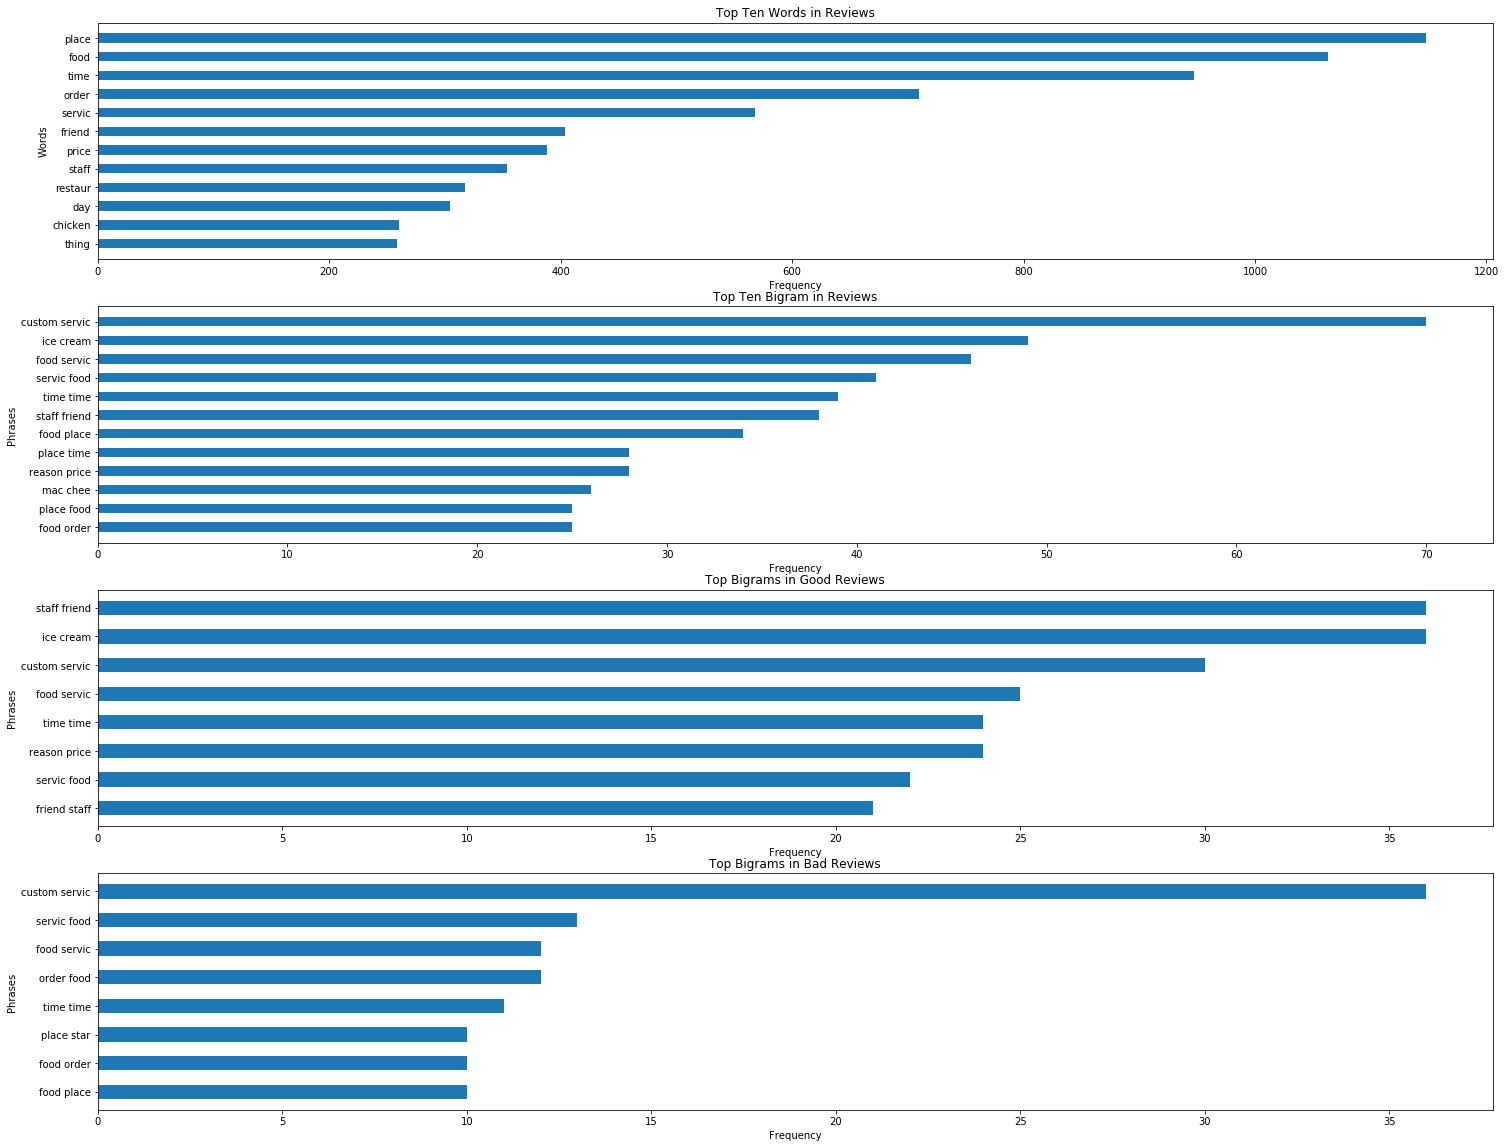

In [11]:
cat_and_loc("Nightlife", "Las Vegas")

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


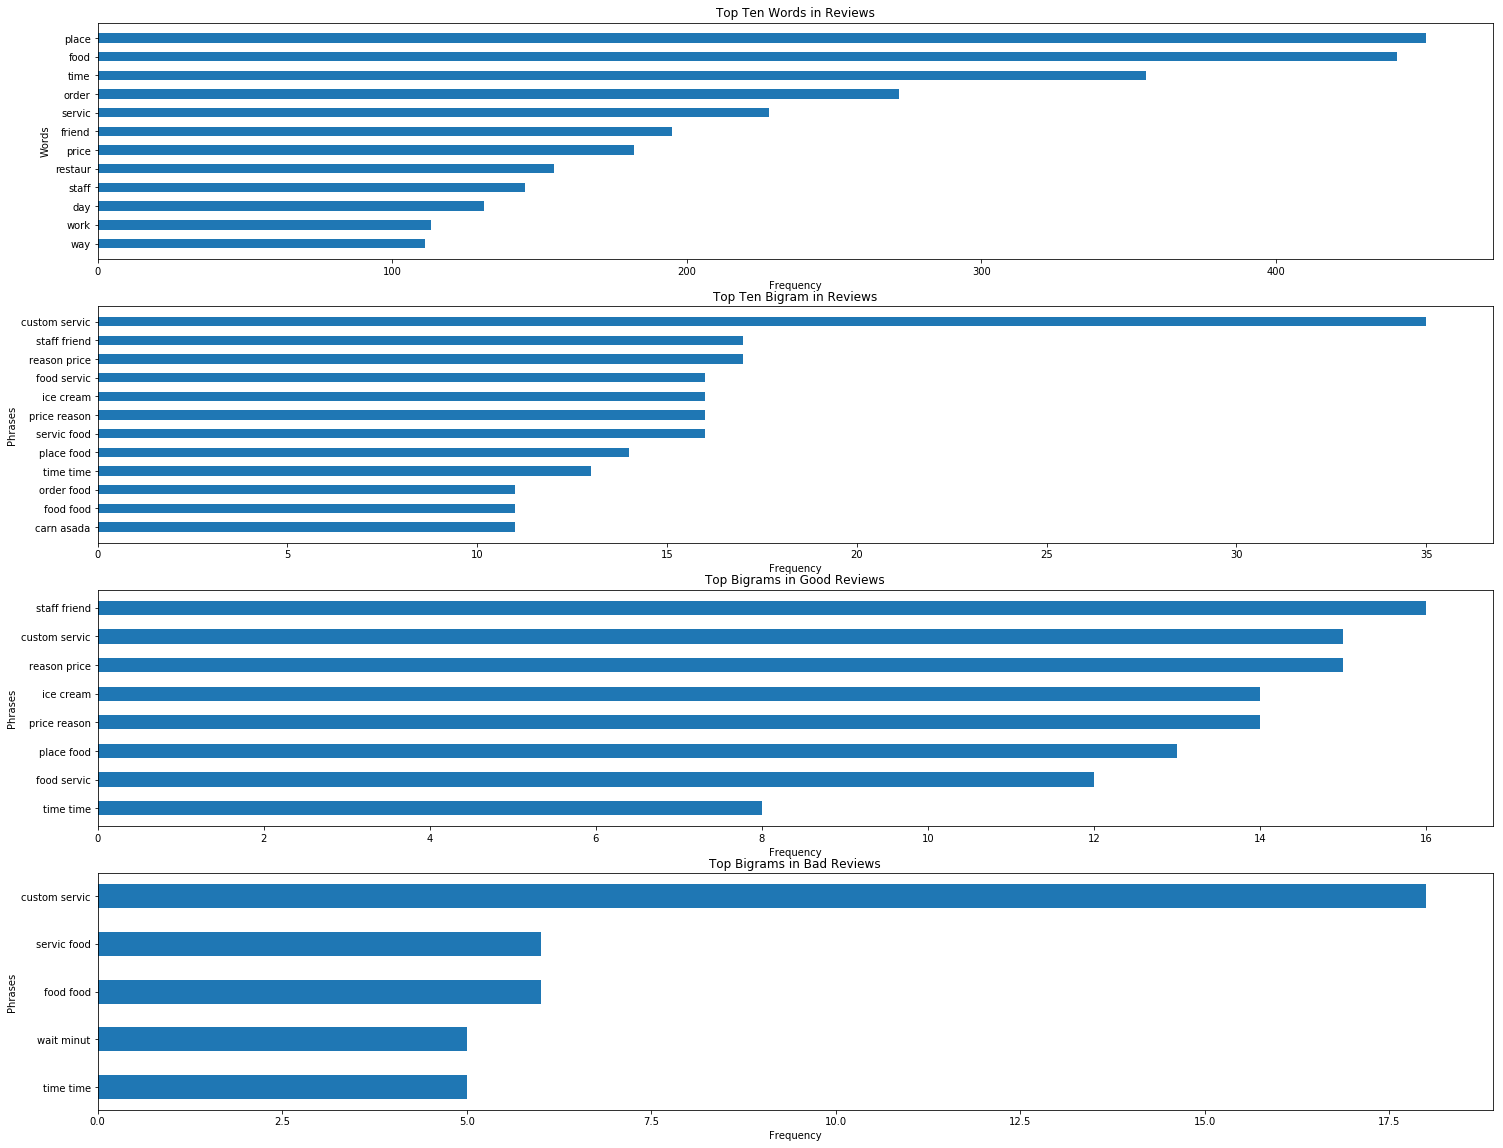

In [12]:
cat_and_loc("Mexican", "Las Vegas")

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


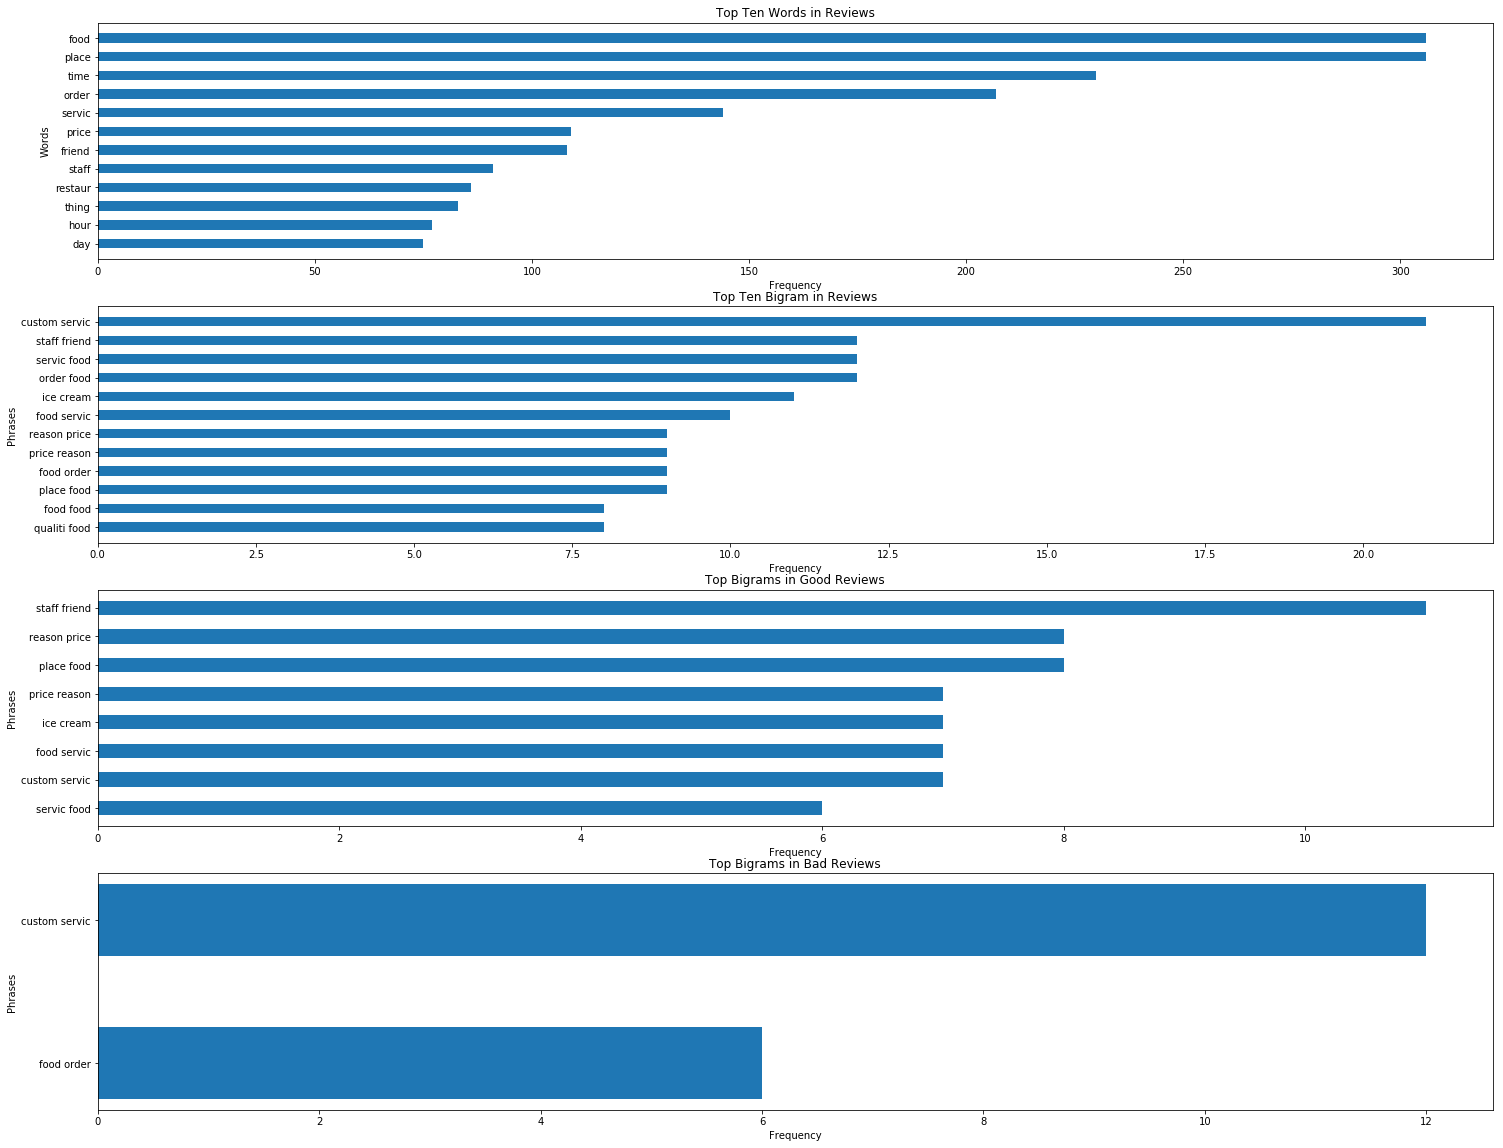

In [13]:
cat_and_loc("Breakfast & Brunch", "Las Vegas")

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


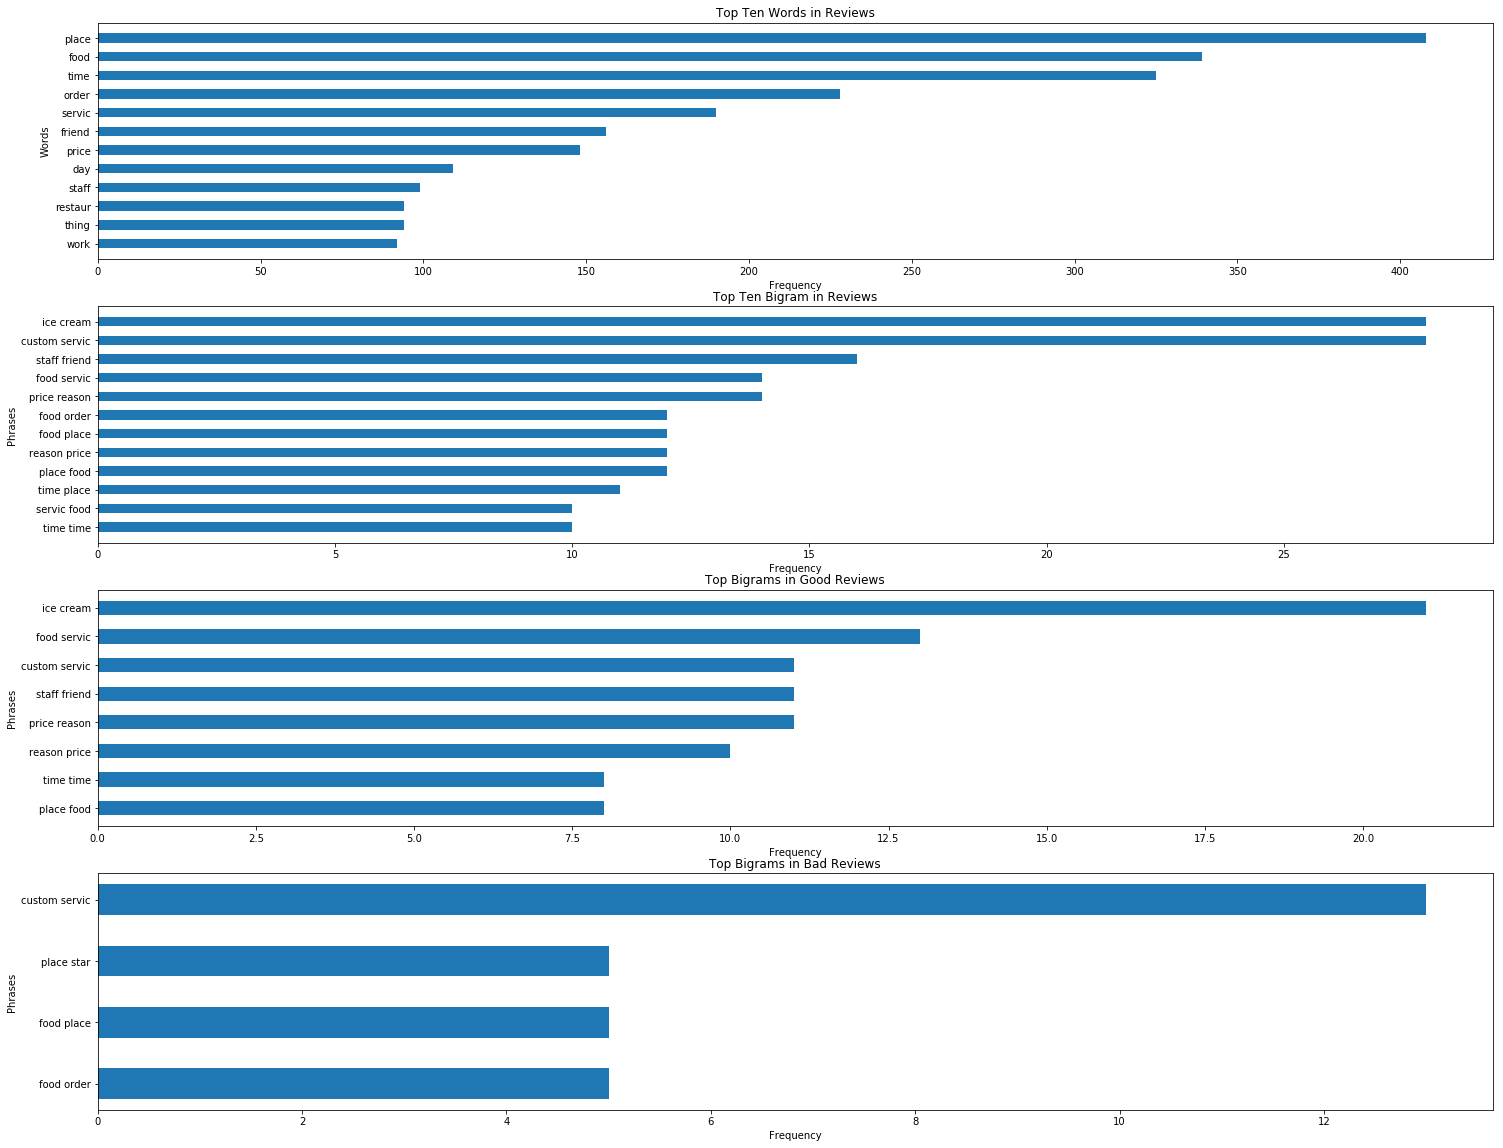

In [14]:
cat_and_loc("Mexican", "Phoenix")

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


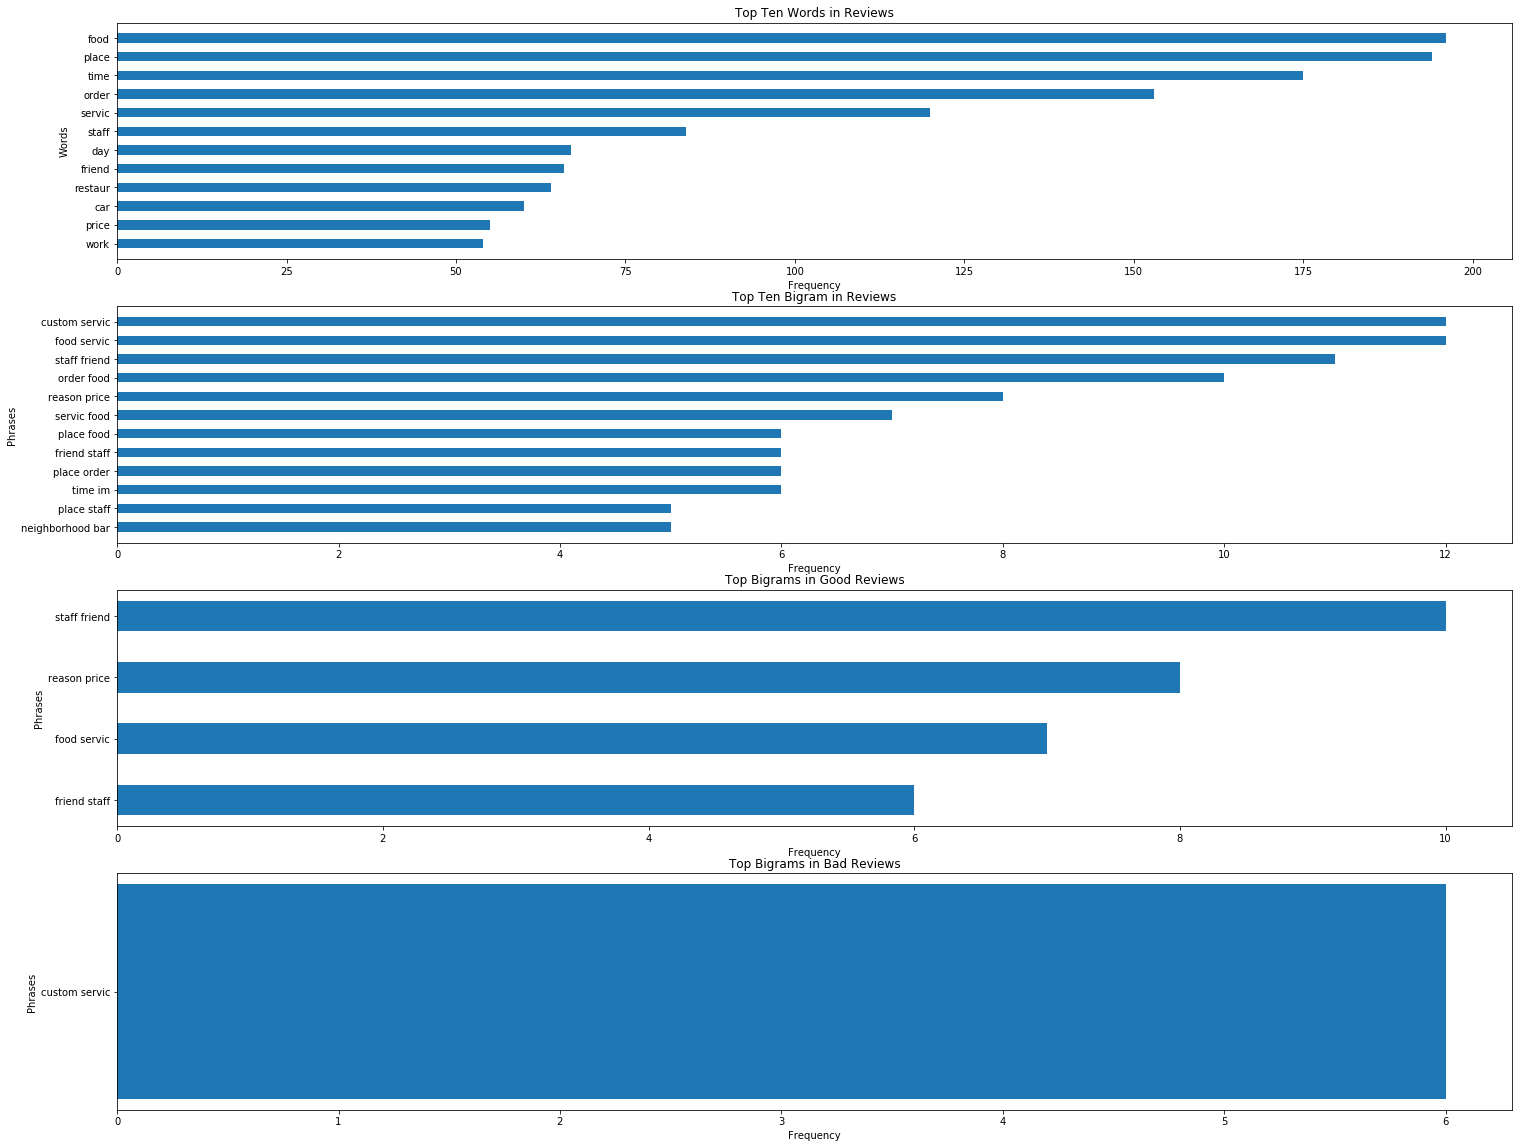

In [15]:
cat_and_loc("Sushi", "Toronto")

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


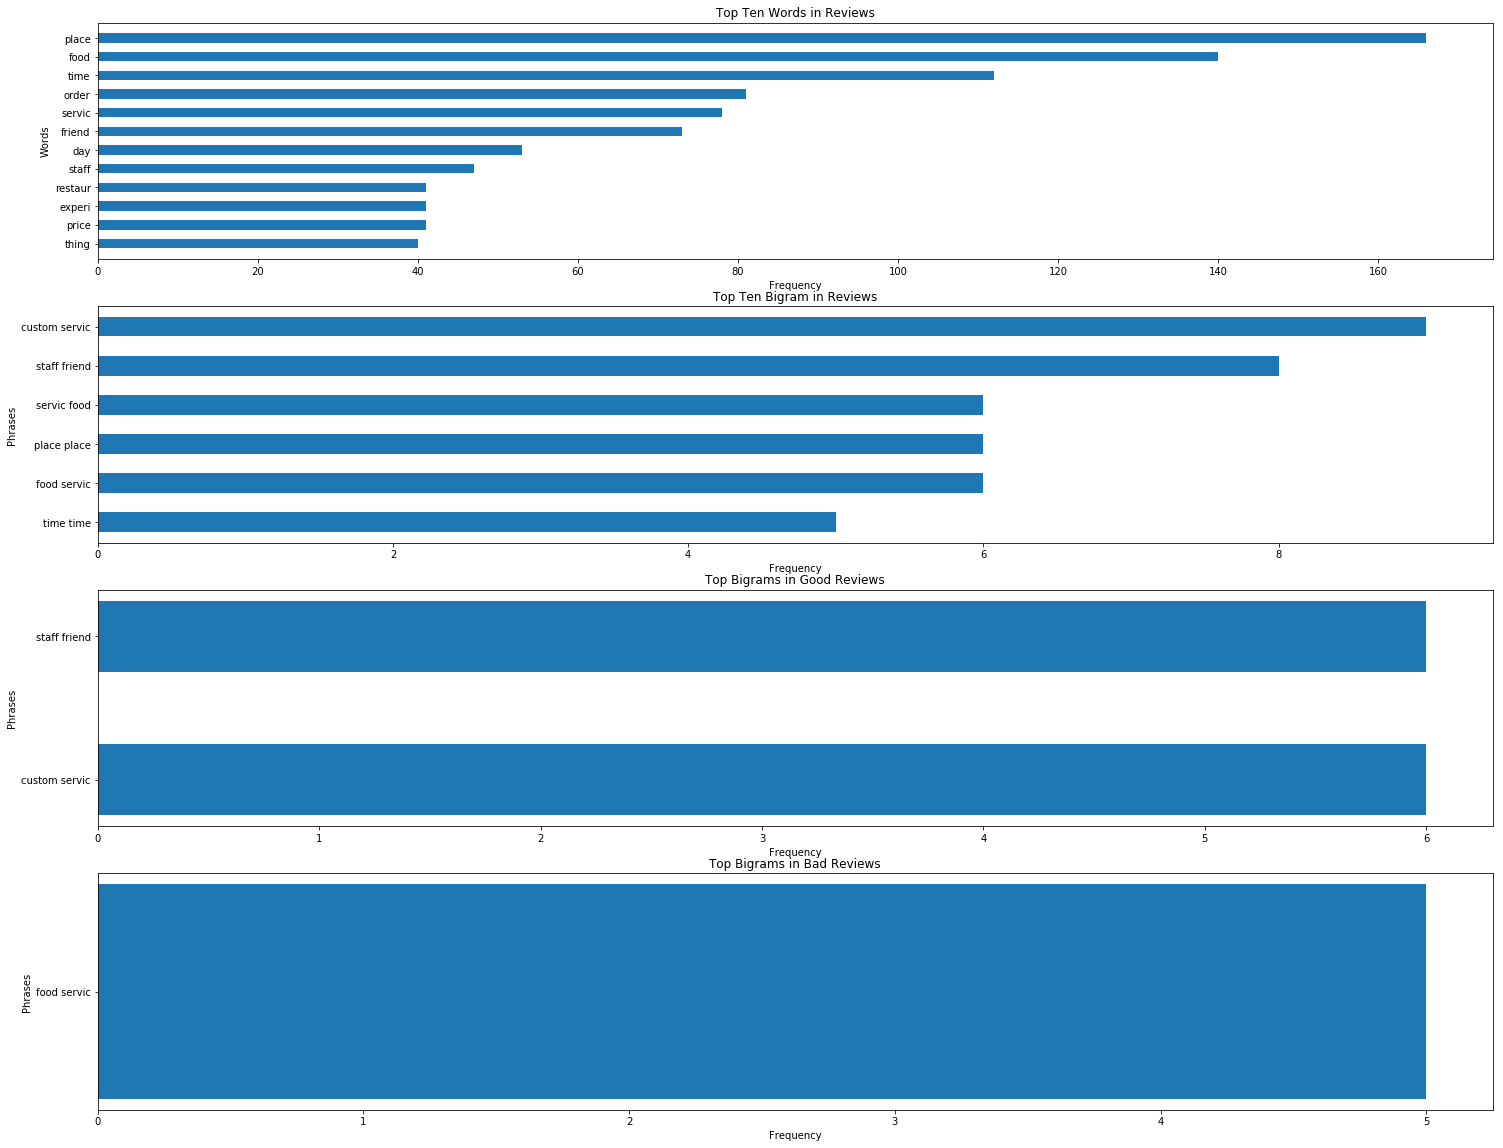

In [16]:
cat_and_loc("Sushi", "Las Vegas")

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


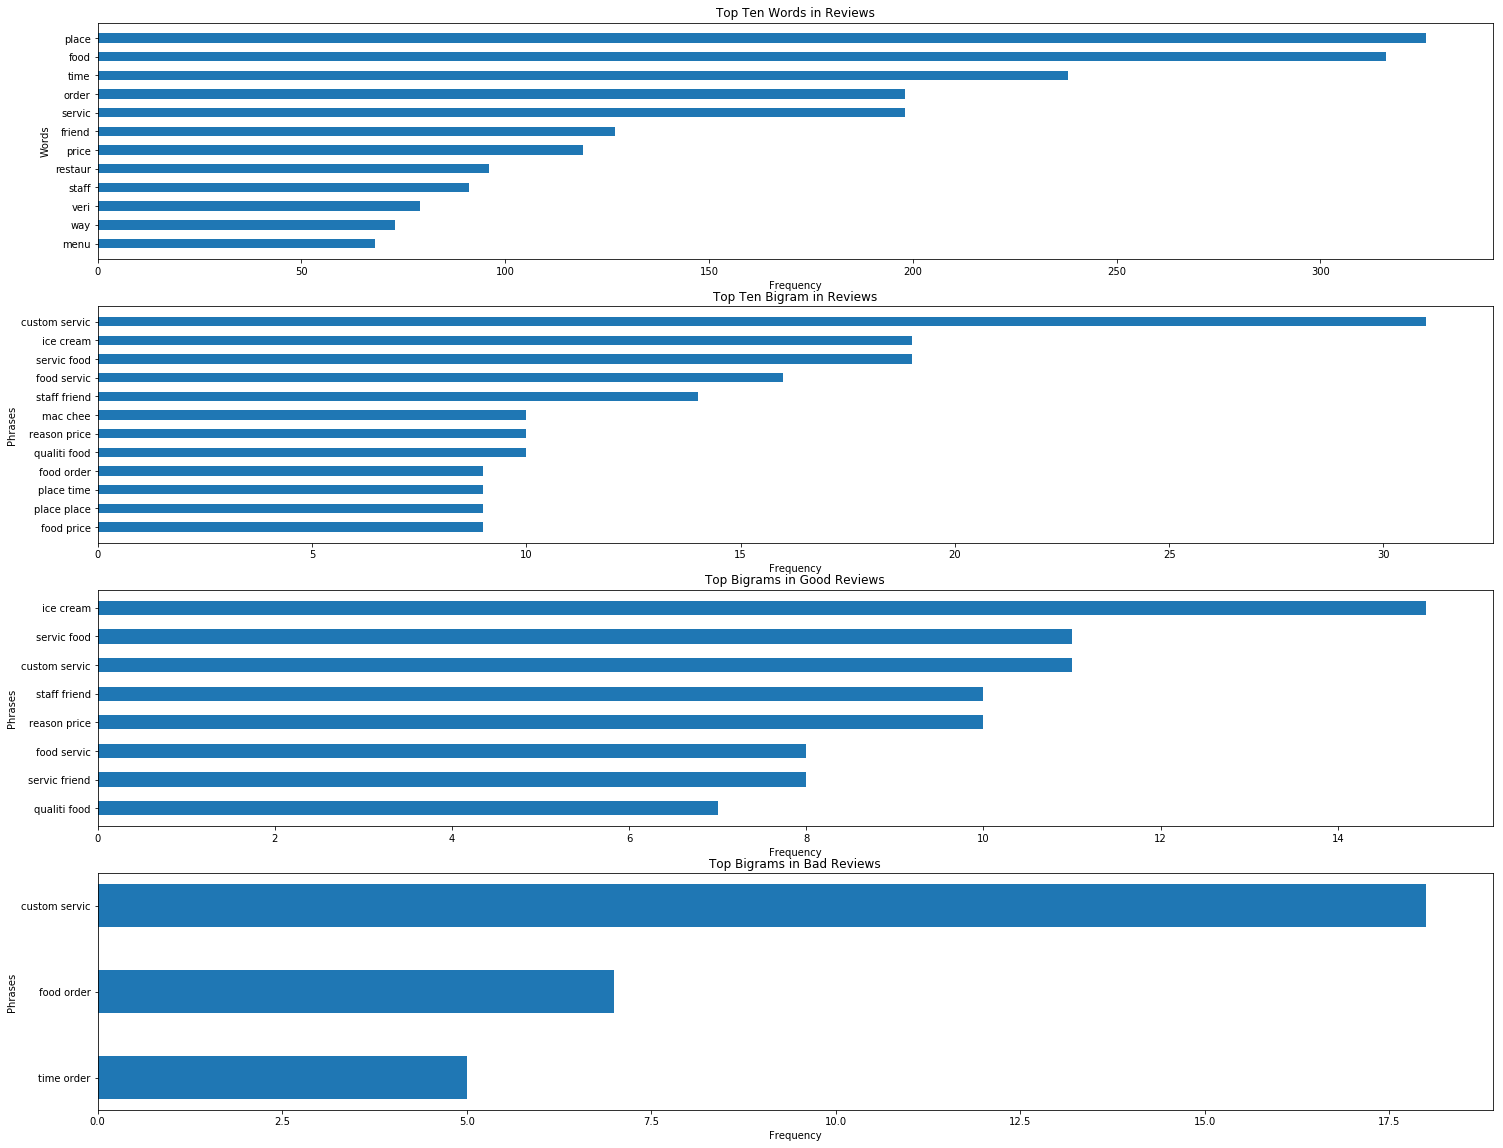

In [17]:
cat_and_loc("Pizza", "Toronto")

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


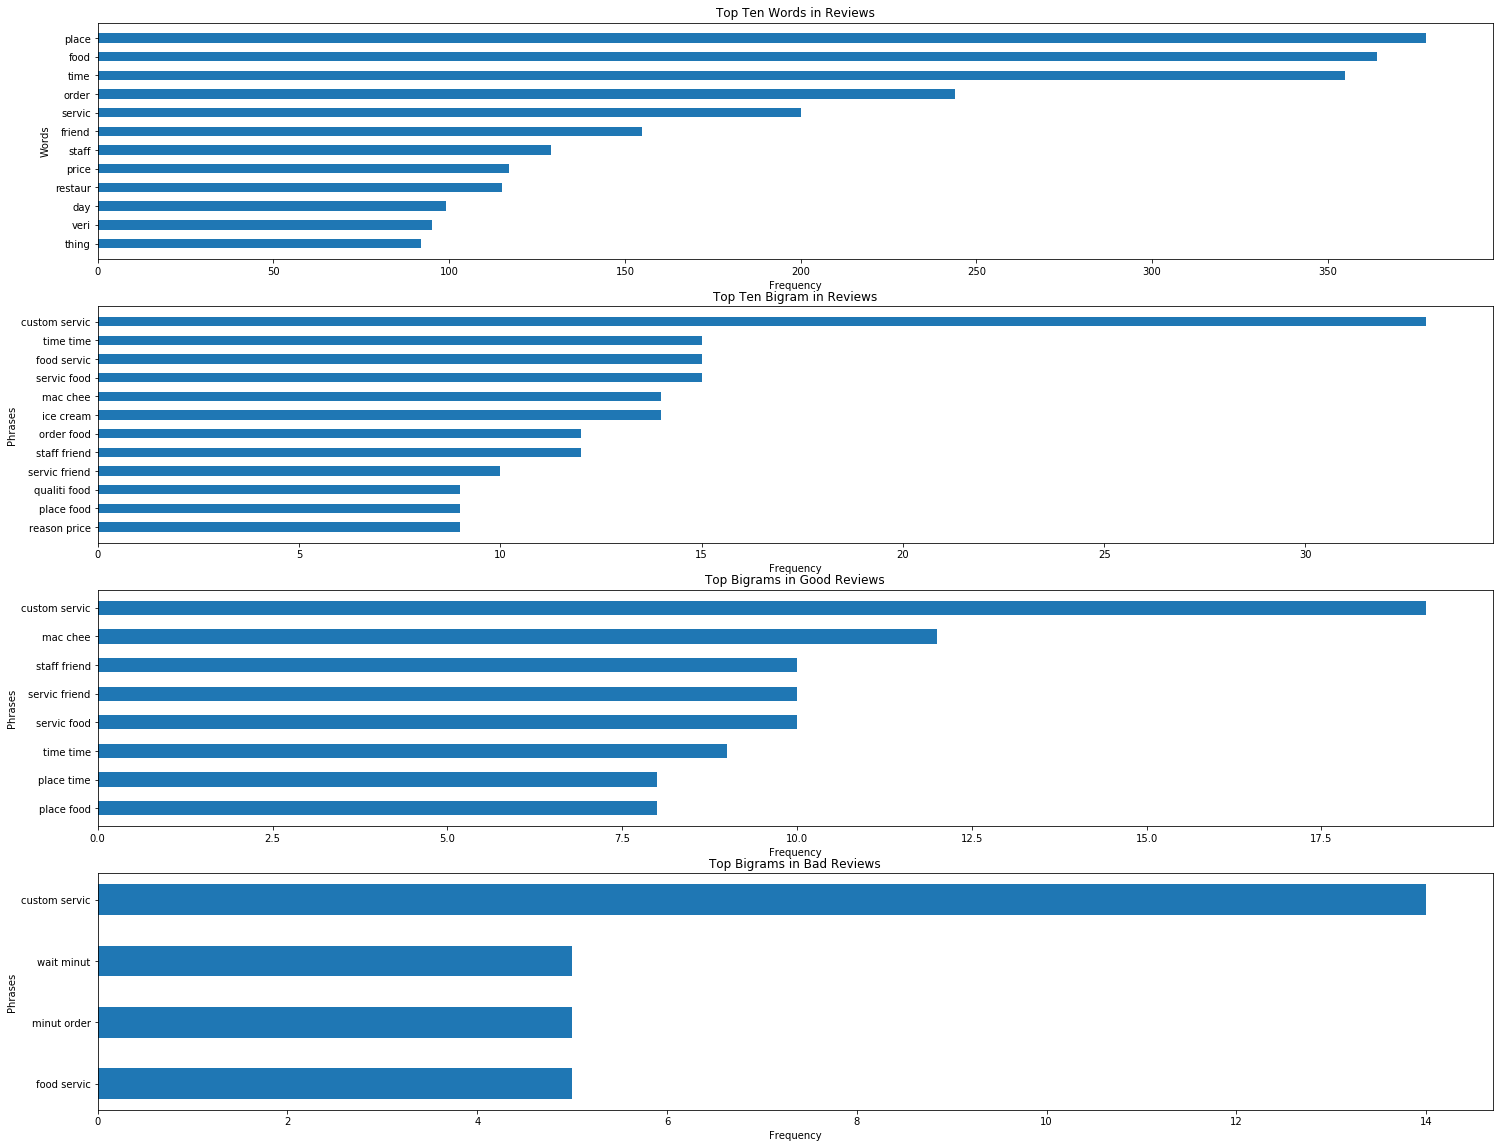

In [18]:
cat_and_loc("Pizza", "Las Vegas")

In [19]:
pd.options.display.max_colwidth = 100 
temp = joined['categories'].str.contains('Restaurants', regex=False)
temp = temp.fillna(False)
temp = joined[temp]
#print(temp['categories'])
temp['categories'].value_counts()

Restaurants, Pizza                                                                                                                                1042
Pizza, Restaurants                                                                                                                                 993
Mexican, Restaurants                                                                                                                               885
Restaurants, Mexican                                                                                                                               853
Chinese, Restaurants                                                                                                                               840
Restaurants, Chinese                                                                                                                               789
Restaurants, Italian                                                                          

In [20]:
temp['city'].value_counts()

Toronto                          7964
Las Vegas                        6450
Phoenix                          3999
Montréal                         3784
Calgary                          2912
Charlotte                        2710
Pittsburgh                       2453
Scottsdale                       1573
Cleveland                        1495
Mississauga                      1447
Mesa                             1167
Madison                          1128
Tempe                            1044
Henderson                         885
Chandler                          866
Markham                           845
Glendale                          720
Gilbert                           577
Brampton                          546
Scarborough                       514
Richmond Hill                     503
Vaughan                           474
North York                        461
Champaign                         425
Peoria                            365
North Las Vegas                   351
Concord     